In [1]:
# <!-- collapse=True -->
# Import necessary modules
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model from ../baseline_models.py
sys.path.insert(0, '..')
from baseline_models import DampedUserMovieBaselineModel

# Use custom matplotlib stylesheet
plt.style.use('../big-darkgrid.mplstyle')

In [2]:
# <!-- collapse=True -->
# This was created in 02_Baselines.ipynb
ratings_through_2013_feather = '../preprocessed/ratings-through-2013.feather'

if exists(ratings_through_2013_feather):
    print("Loading {}".format(ratings_through_2013_feather))
    ratings_df = pd.read_feather(ratings_through_2013_feather)
else:
    raise ValueError("{} doesn't exits. Run 02_Baselines.ipynb to create.")
display(ratings_df.tail())

Loading ../preprocessed/ratings-through-2013.feather


,userId,movieId,rating,timestamp,year,month,day,hour,minute
19153905,120609,81562,3.0,2013-12-31 23:57:27,2013,12,31,23,57
19153906,120609,356,2.5,2013-12-31 23:57:36,2013,12,31,23,57
19153907,120609,74458,4.0,2013-12-31 23:57:47,2013,12,31,23,57
19153908,44501,70533,4.5,2013-12-31 23:58:07,2013,12,31,23,58
19153909,44501,96821,4.0,2013-12-31 23:58:34,2013,12,31,23,58


In [13]:
class SGDRecommender():
    def __init__(self, k=5, learning_rate=0.1, max_epochs=15, error_metric='mae',
                 user_reg=0.0, item_reg=0.0, user_bias_reg=0.0, item_bias_reg=0.0,
                 damping_factor=25, minibatch_size=1, verbose=True):
        self.k = k
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.error_metric = error_metric
        self.user_reg = user_reg
        self.item_reg = item_reg
        self.user_bias_reg = user_bias_reg
        self.item_bias_reg = item_bias_reg
        self.damping_factor = damping_factor
        self.minibatch_size = minibatch_size
        self.verbose = verbose
        
        self.U = None
        self.I = None
        self.initialized = False

    def _get_rating_matrix(self, X):
        """Private function to generate a ratings matrx and mappings for
        the user and item ids to the row and column indices
        
        Parameters
        ----------
        X : pandas.DataFrame, shape=(n_ratings,>=3)
            First 3 columns must be in order of user, item, rating.
        
        Returns
        -------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
        user_map : pandas Series, shape=(n_users,)
            Mapping from the original user id to an integer in the range [0,n_users)
        item_map : pandas Series, shape=(n_items,)
            Mapping from the original item id to an integer in the range [0,n_items)
        """
        user_col, item_col, rating_col = X.columns[:3]
        rating = X[rating_col]
        user_map = pd.Series(
            index=np.unique(X[user_col]),
            data=np.arange(X[user_col].nunique()),
            name='user_map',
        )
        item_map = pd.Series(
            index=np.unique(X[item_col]),
            data=np.arange(X[item_col].nunique()),
            name='columns_map',
        )
        user_inds = X[user_col].map(user_map)
        item_inds = X[item_col].map(item_map)
        rating_matrix = (
            pd.pivot_table(
                data=X,
                values=rating_col,
                index=user_inds,
                columns=item_inds,
            )
            .fillna(0)
            .values
        )
        return rating_matrix, user_map, item_map

    def _calc_train_error(self, U, I, mu, b_u, b_i, R, R_selector=None):
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = np.dot(U, I.T) + mu + b_u[:, None] + b_i[None, :]
        if self.error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupported error metric".format(metric))
        return error
    
    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        user_col, item_col, rating_col = X.columns[:3]
        self.baseline_algo = DampedUserMovieBaselineModel(damping_factor=self.damping_factor)
        self.baseline_algo.fit(X[[user_col, item_col]], X[rating_col])
        self.mu = X[rating_col].mean()
        self.b_u, self.b_i = self.baseline_algo.b_u.values, self.baseline_algo.b_i.values
        self.R, self.user_map, self.item_map = self._get_rating_matrix(
            X[[user_col, item_col, rating_col]]
        )
        n_users, n_items = self.R.shape
        # self.U = 3 * np.random.rand(self.k, n_users)
        # self.I = 3 * np.random.rand(self.k, n_items)
        # self.I[0, :] = self.R[self.R != 0].mean(axis=0) # Avg. rating for each movie
        self.U = np.random.normal(scale=1.0/self.k, size=(n_users, self.k))
        self.I = np.random.normal(scale=1.0/self.k, size=(n_items, self.k))
        # self.U = np.zeros((n_users, self.k))
        # self.I = np.zeros((n_items, self.k))
        self.epoch = 0
        self.train_errors = []
        self.initialized = True
        
    def fit(self, X, n_epochs=None):
        """Fit model to training data X.
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        
        Returns
        -------
        self
            This allows chaining like `SGDRecommender().fit(X_train).predict(X_test)`
        """
        X = X.copy()
        if not self.initialized:
            self._fit_init(X)
        X.iloc[:, 0] = X.iloc[:, 0].map(self.user_map)
        X.iloc[:, 1] = X.iloc[:, 1].map(self.item_map)
        
        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0
        
        n_users, n_items = self.R.shape
        
        # Repeat until convergence
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Shuffle X
            X = X.sample(frac=1)
            if self.minibatch_size == 1:
                for row in X.itertuples():
                    index, user, item, rating = row[:4]
                    pred = self.predict_1_train(user, item)
                    err = pred - self.R[user, item]
                    self.b_u[user] -= self.learning_rate * (err + self.user_bias_reg * self.b_u[user])
                    self.b_i[item] -= self.learning_rate * (err + self.item_bias_reg * self.b_i[item])
                    self.U[user, :] -= self.learning_rate * (
                        err * self.I[item, :] + self.user_reg * self.U[user, :]
                    )
                    self.I[item, :] -= self.learning_rate * (
                        err * self.U[user, :] + self.item_reg * self.I[item, :]
                    )
            error = self._calc_train_error(self.U, self.I, self.mu, self.b_u, self.b_i, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self
    
    def predict_1_train(self, user, item):
        pred = self.mu + self.b_u[user] + self.b_i[item]
        pred += np.dot(self.U[user, :], self.I[item, :])
        return pred
    
    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            self.predict_1_train(u_ind, i_ind)
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        return X['rating']

In [16]:
n_splits = 5
max_epochs = 20
k = 20
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
small_df = ratings_df.iloc[:100000]
train_errs = np.zeros((n_splits, max_epochs))
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}".format(i_fold))
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    rec = SGDRecommender(k=k, learning_rate=0.01, user_reg=0.0, item_reg=0.0,
                         user_bias_reg=0.0, item_bias_reg=0.0, max_epochs=max_epochs)
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)

i_fold=0
[Epoch 0/20] train error: 0.6853024815117609
[Epoch 0/20] test MAE: 0.6927362019990229
[Epoch 1/20] train error: 0.677909370733458
[Epoch 1/20] test MAE: 0.6875338952897795
[Epoch 2/20] train error: 0.6721377571312362
[Epoch 2/20] test MAE: 0.6845592732068323
[Epoch 3/20] train error: 0.6683519087995206
[Epoch 3/20] test MAE: 0.683784283186522
[Epoch 4/20] train error: 0.6632249738132299
[Epoch 4/20] test MAE: 0.6827474858547241
[Epoch 5/20] train error: 0.6571783231265838
[Epoch 5/20] test MAE: 0.681765262117068
[Epoch 6/20] train error: 0.6479053526736925
[Epoch 6/20] test MAE: 0.680753263239002
[Epoch 7/20] train error: 0.6327604543845287
[Epoch 7/20] test MAE: 0.6786488961040784
[Epoch 8/20] train error: 0.6130758855605449
[Epoch 8/20] test MAE: 0.6776149671392501
[Epoch 9/20] train error: 0.5893477968189365
[Epoch 9/20] test MAE: 0.6763657632889793
[Epoch 10/20] train error: 0.5657624622837175
[Epoch 10/20] test MAE: 0.6756513515222372
[Epoch 11/20] train error: 0.5437584

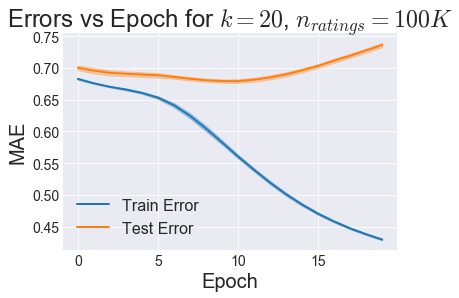

In [18]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k={}$, $n_{{ratings}}=100K$'.format(k))
plt.show()

In [19]:
n_splits = 5
max_epochs = 10
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 5, 10, 20, 50]
small_df = ratings_df.iloc[:100000]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = SGDRecommender(k=k, learning_rate=0.01, verbose=False, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        # print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1, k=5, k=10, k=20, k=50, 
i_fold=1: k=1, k=5, k=10, k=20, k=50, 
i_fold=2: k=1, k=5, k=10, k=20, k=50, 
i_fold=3: k=1, k=5, k=10, k=20, k=50, 
i_fold=4: k=1, k=5, k=10, k=20, k=50, 


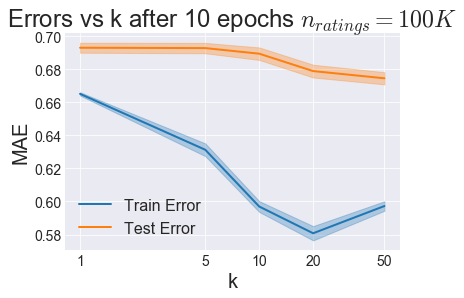

In [20]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel('k')
plt.ylabel('MAE')
plt.title(r'Errors vs k after {} epochs $n_{{ratings}}=100K$'.format(max_epochs))
plt.show()